In [5]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torch.utils.data as data

import random
import math
import time

from tqdm import tqdm

import matplotlib.pyplot as plt

import json

In [6]:
en_file = 'data/en-US.jsonl'

def read_data(path):
    with open(path, 'r') as file:
        return pd.DataFrame([json.loads(line) for line in file])

df = read_data(en_file)
df.head()


,id,locale,partition,scenario,intent,utt,annot_utt,worker_id
0,0,en-US,test,alarm,alarm_set,wake me up at five am this week,wake me up at [time : five am] [date : this week],1
1,1,en-US,train,alarm,alarm_set,wake me up at nine am on friday,wake me up at [time : nine am] on [date : friday],1
2,2,en-US,train,alarm,alarm_set,set an alarm for two hours from now,set an alarm for [time : two hours from now],1
3,3,en-US,test,audio,audio_volume_mute,quiet,quiet,1
4,4,en-US,train,audio,audio_volume_mute,olly quiet,olly quiet,1


In [7]:
def df_select(df, col, categories):
    dfs = [df[df[col] == c] for c in categories]
    return dfs[0] if len(dfs) == 1 else dfs

train_df, dev_df, test_df = df_select(df, 'partition', ['train', 'dev', 'test'])

In [78]:
def categories(df, label):
    return set(df[label])


def df_select(df, col, label):
    return df[df[col] == label]


def categorize(df, label, f):
    C = categories(df, label)
    return { c: f((df, label, c)) for c in C }


def hierarchy(df, column_sequence, type='root', value=None, f=lambda x: None):
    # a useful f function:
    # f = lambda x: df_select(*x)

    if value:
        df = df_select(df, type, value) 

    sub = col = None
    
    if len(column_sequence) > 0:
        col = column_sequence[0]

        C = categorize(df, col, f)
        sub = { c: hierarchy(df, column_sequence[1:], col, c, f) for c in C }
    
    return {
        'name': value,
        'category': type,
        'children_type': col,
        'children': sub,
        'data': df,
        }


def hierarchy_drop_data(h):
    if type(h) != dict:
        return h
    
    return { k: hierarchy_drop_data(v) for k,v in h.items() if k != 'data' and not (type(v) == dict and len(v) == 0)}


def hierarchy_count_tree(h):
    def count_dict(h):
        if not h:
            return None
        if not h['children']:
            return None
        
        children = { child : len(h_child['data']) for child, h_child in h['children'].items() if child and h_child }
        return children
    
    def tree(h):
        if not h:
            return None
        
        counts = count_dict(h)
        children = { child : tree(value) for child, value in h['children'].items() } if h['children'] else None
        
        return {
            'counts': counts,
            'subtrees': children
        }
    
    return tree(h)
    

def count_tree_leaves(t):
    count = 0
    
    if not t['subtrees']:
        return 1
    
    for _, subtree in t['subtrees'].items():
        count += count_tree_leaves(subtree)

    return count

column_sequence=['scenario', 'intent', 'utt']
h = hierarchy(df, column_sequence)


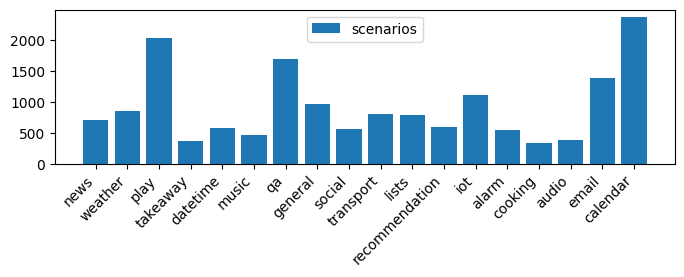

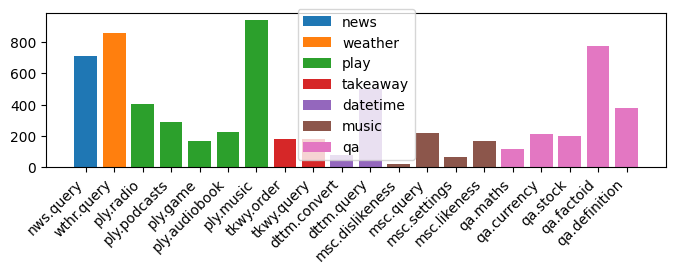

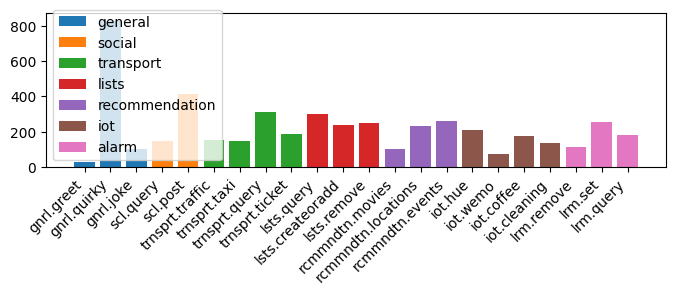

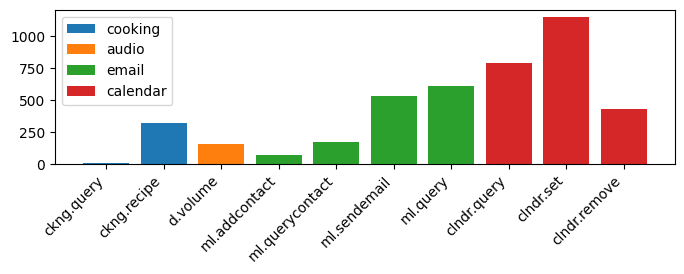

In [94]:
t = hierarchy_count_tree(hierarchy(df, column_sequence[0:2]))

def remove_vowels(word):
    return ''.join(l for l in list(word) if l not in 'aiueo')
    
def plot_tree(t, label='', plt_setup=True):
    if not t:
        return
    
    counts = t['counts']
    
    if not counts:
        return
    
    if plt_setup:
        plt.figure(figsize=(8,2))
    
    keys = list(counts.keys())
    if '_' in keys[0]:
        keys = [k.split('_') for k in keys]
        keys = [(remove_vowels(k[0]) if len(k[0]) > 3 else k[0]) + '.' + k[1] for k in keys]
    
    plt.bar(keys, counts.values(), label=label)
    
    if plt_setup:
        plt.xticks(rotation=45, ha='right')
        plt.legend()


def plot_trees(T):
    plt.figure(figsize=(8,2))

    for name, t in T:
        plot_tree(t, name, False)
    
    plt.xticks(rotation=45, ha='right')
    plt.legend()

def plot_trees_in_groups(subtrees, gsize=7):
    subtrees = list(subtrees.items())

    step = gsize
    for i in range(0, len(subtrees), step):
        plot_trees(subtrees[i: i+step])

# def plot_all_trees(t):
#     subtrees = t['subtrees']
#     if not subtrees:
#         return
    
#     S = list(subtrees.items())
#     plot_trees_in_groups(S)

#     i = 0
#     for st in subtrees.values():
#         plot_all_trees(st)
#         i += 1
#         if i > 3:
#             break
    
plot_tree(t, 'scenarios')
plot_trees_in_groups(t['subtrees'])


dict_keys(['news', 'weather', 'play', 'takeaway', 'datetime', 'music', 'qa', 'general', 'social', 'transport', 'lists', 'recommendation', 'iot', 'alarm', 'cooking', 'audio', 'email', 'calendar'])

In [98]:
# t = hierarchy_count_tree(h)
# # leaf_count = count_tree_leaves(t)
# child_count = len(t['subtrees'])

# def grid_size(x, ncols = 2):
#     return ncols, x // ncols + x % ncols

# ncols, nrows = grid_size(child_count)
# nrows = 2
# # ncols, nrows = 2, 10
# plt.figure(figsize=(5 * 10 * ncols, 5 * 5 * nrows))  
# fig, axes = plt.subplots(nrows, ncols)

# counts = t['counts']
# names = ['scenario']
# # plt.bar(list(counts.keys()), list(counts.values()), label=names[0])

# width = 0.7  # the width of the bars

# names = []
# i = 0
# j = 0
# for name, subtree in t['subtrees'].items():
#     counts = subtree['counts']
#     keys = list(counts.keys())
#     keys = [k.split('_')[1] for k in keys]
    
#     values = list(counts.values())

#     if j+1 > ncols * nrows:
#         break
#     # if i + 1 > 30:
#     #     i = 0
#     #     break

#     # plt.bar(keys, values, label=name, legend=name)
#     ax = axes[j//ncols, j%ncols]

#     ax.bar(keys, values, width, label=name)
#     ax.set_xticklabels(keys, rotation=45)

#     # ax.set_xlabel('Categories')
#     # ax.set_ylabel('Values')
#     # ax.set_title('Comparison of Values by Category')
#     ax.legend()

    
#     # for i in range(0, len(t), 4):
#     #     plt.bar(keys[i:i+4], values[i:i+4], label=name)
#     #     break

#     i += len(counts)
#     j += 1


# plt.xticks(rotation=45, ha='right')
# # ax.set_xticklabels(names)

# plt.show()

In [99]:
# def df_group_counts(df, col):
#     count_df = df.groupby(by=col)['id'].count()
   
#     # bar = None
#     # if bar_plot:
#     #     plt.xticks(rotation=45, ha='right')
#     #     
#     # bar = plt.bar(count_df.keys(), count_df)
    
#     return count_df.keys(), count_df

# def plot_bar(df, label, select=None):
#     dfs = df_select(df, *select) if select else [df]
#     print(dfs)
#     plt.figure(figsize=(30, 20))  
#     ncols, nrows = 2, len(dfs) // 2 + len(dfs) % 2
#     fig, axes = plt.subplots(nrows, ncols)

#     for ax, df in zip(axes, dfs):
#         ax.bar(*df_group_counts(df, label), label=label)
#         ax.set_xticklabels(ax.get_xticks(), rotation=45)

#     plt.bar()
#     plt.tight_layout()
#     # plt.legend()
#     return plt.show()

# # plot_bar(train_df, 'scenario', ['email', ])
# # plt.bar(*df_group_counts(train_df, 'scenario'), label='scenario')
# # plt.bar(*df_group_counts(df_select(train_df, 'scenario', ['play']), 'intent'))

# # plot_bar(df, 'intent', ('scenario', ['email', 'cooking']))

# # df_group_counts(train_df, 'scenario', bar_plot=True)

# # df_group_counts(df_select(df, 'scenario', ['music']), 'intent', True)

# # counts

# # train_df.groupby('scenario').count()


# # from datasets import Dataset
# # df_select(train_df, 'scenario', ['alarm']).groupby('intent')['id'].count()
